# CYPLAN101 Fall 2025 - Lab 9 (Part II): Park Site Selection Using Contextual Paradigms

## Learning Objectives:

By the end of this exercise, you will be able to:

1. Recognize how different geographic data types (vector and raster) provide context for spatial analysis
2. Create normalized indices from multiple criteria to evaluate site suitability
3. Combine vector data (points, polygons) with raster data (satellite imagery derivatives)
4. Use proximity analysis, raster calculations, and spatial joins
5. Identify optimal park locations based on environmental justice and accessibility criteria

---
As a reminder, we are conducting a site suitability analysis for locating a new park in the city of Berkeley. Your analysis must consider three key criteria:

1. **Low Tree Canopy Coverage**: Areas with less existing tree cover may benefit more from a new park (environmental criterion)
2. **Lower Median Household Income**: Prioritize underserved communities with less access to green space (equity criterion)
3. **Proximity to AC Transit Stops**: Ensure the park is accessible via public transportation (accessibility criterion)

In the first part of this lab, you aggregated data representing each of these variables to a GeoDataFrame containing census tract geometry.  **Now you will calculate and visualize your new index.**

---

In [112]:
# Install required packages
!pip install geopandas rasterio rasterstats contextily -q

In [113]:
# Import libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
import warnings
warnings.filterwarnings('ignore')

### Step 1: Standardize Your Variables
In this step you will put all variables on a common scale. Here we will apply two methods for creating an index: standardizing and normalizing.

For standardization you will calculate a z-score:

<br>

# $z = \frac{x - \mu}{\sigma}$

<br>

where...
* x = input data
* μ = average of the series
* σ = SD of the series

> z-scores tell you about deviation from average behavior and assume the data has a largely normal distribution.

Once you have calculated the z-scores for each variable, aggregate them into a single index value by averaging them.

In [114]:
# Importing GeoDataFrame
gdf = gpd.read_file("data/berkeleyCensusGdf_with_stops_and_canopy.gpkg")
gdf = gdf.rename(columns={'B19013_001E': 'MEDIAN INCOME',
                  'B01003_001E': 'TOTAL POPULATION'})


cols = ['MEDIAN INCOME', 'TOTAL POPULATION' , 'tree_canopy_pct', 'num_buffered_stops']
gdf_norm = gdf.copy()[cols]
gdf_norm[cols] = gdf_norm[cols].astype(float)

display(gdf_norm.head(3))


,MEDIAN INCOME,TOTAL POPULATION,tree_canopy_pct,num_buffered_stops
0,250001.0,3094.0,35.300091,14.0
1,225880.0,2093.0,15.632873,5.0
2,159612.0,4395.0,13.613267,6.0


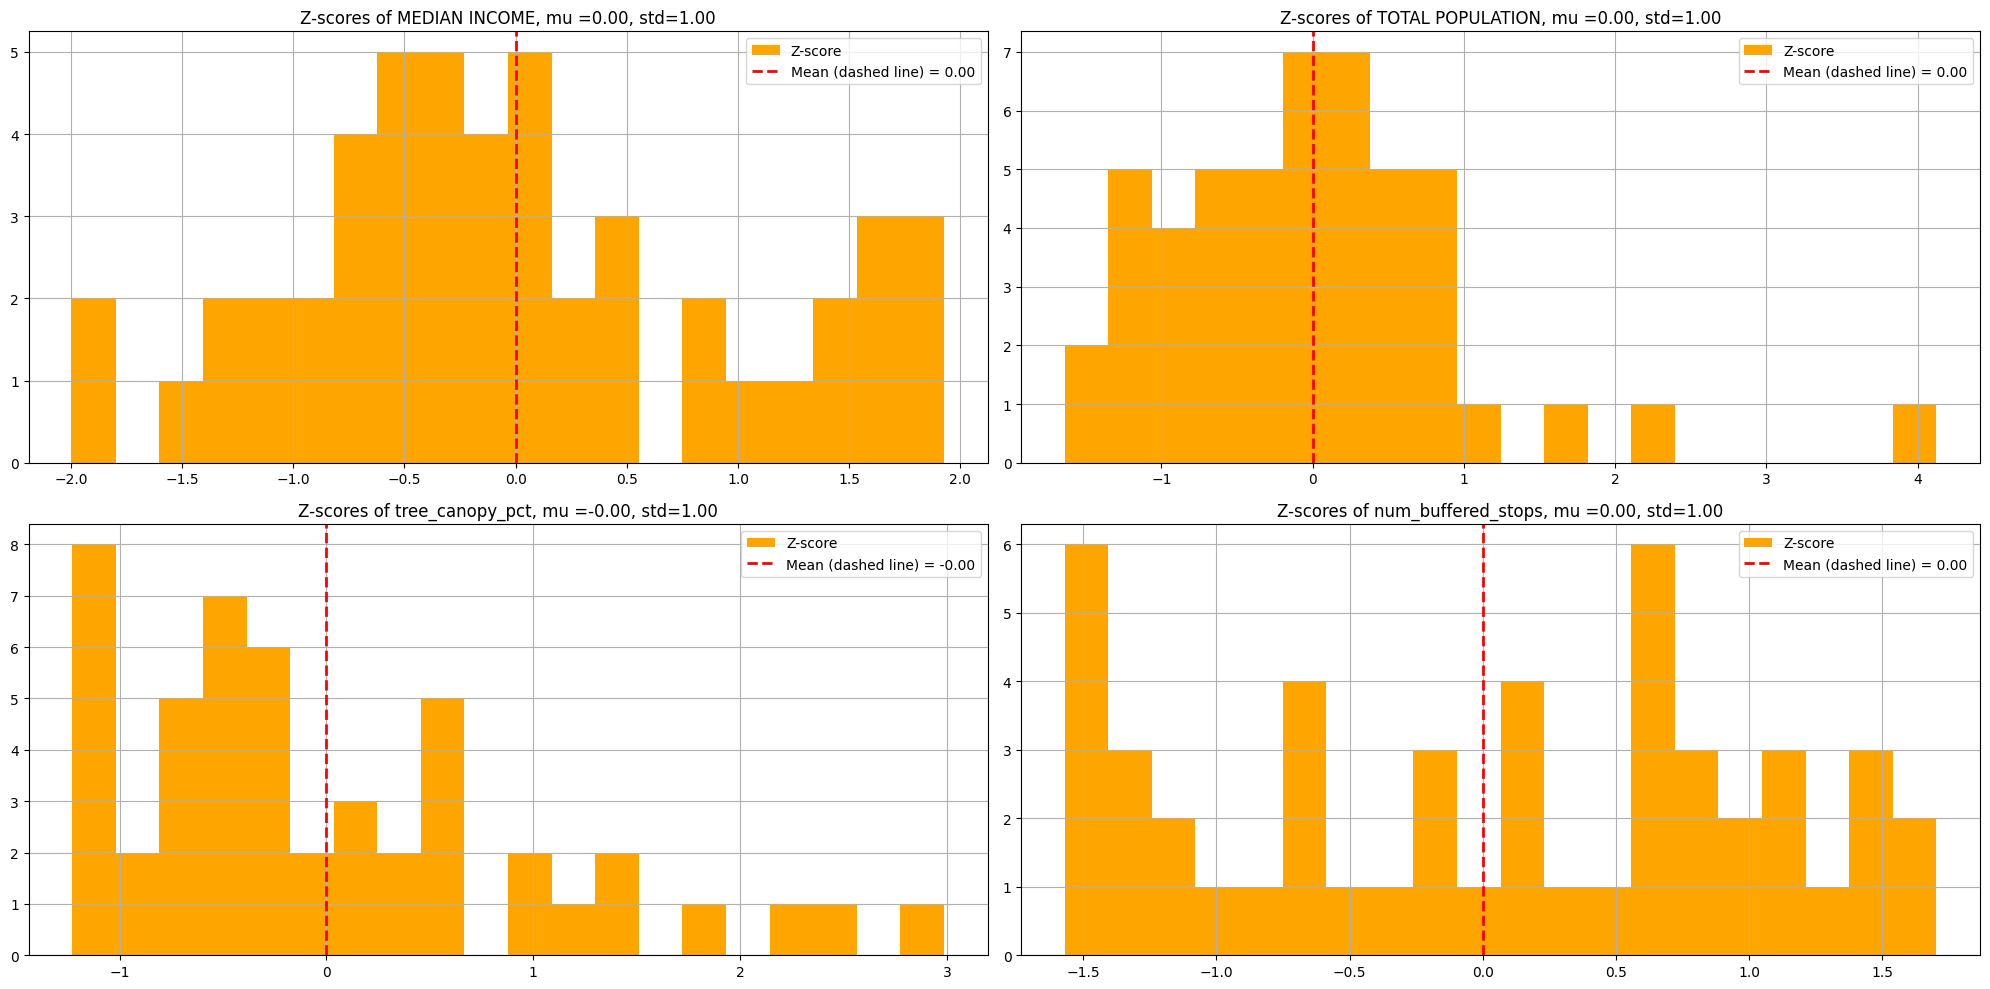

In [115]:
# Use this cell to calculate the z-scores for each index variable in your GeoDataFrame
def standardize(df: gpd.GeoDataFrame, col: str):
  x = df[col]
  mu, std = np.mean(x), np.std(x)
  return (x - mu) / std

plt.subplots(nrows=2, ncols=2, figsize=(20,10))
for i, col in enumerate(cols):
    gdf_norm[col + '_zscore'] = standardize(gdf_norm, col)
    ax = plt.subplot(2, 2, i+1)
    gdf_norm[col + '_zscore'].hist(bins=20, ax=ax, color='orange', label='Z-score')
    # Add dashed mean line and label it so it appears in the legend
    ax.axvline(np.mean(gdf_norm[col + '_zscore']), color='red', linestyle='dashed', linewidth=2, label='Mean (dashed line) = {:.2f}'.format(np.mean(gdf_norm[col + '_zscore'])))
    ax.set_title(f'Z-scores of {col}, mu ={np.mean(gdf_norm[col + "_zscore"]):.2f}, std={np.std(gdf_norm[col + "_zscore"]):.2f}')
    ax.legend()
plt.tight_layout()

Z-score index summary:
count    4.900000e+01
mean    -1.132881e-17
std      5.833682e-01
min     -1.134842e+00
25%     -3.311265e-01
50%      7.517622e-04
75%      2.375274e-01
max      1.536601e+00
Name: index_z, dtype: float64


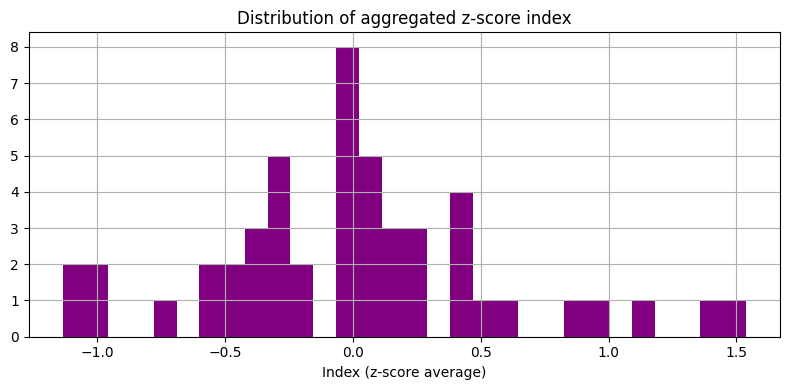

In [116]:
# Aggregate z-score columns into a single index by averaging across z-score columns
z_cols = [c + '_zscore' for c in cols]
gdf_norm['index_z'] = gdf_norm[z_cols].mean(axis=1)
print('Z-score index summary:')
print(gdf_norm['index_z'].describe())

plt.figure(figsize=(8,4))
gdf_norm['index_z'].hist(bins=30, color='purple')
plt.title('Distribution of aggregated z-score index')
plt.xlabel('Index (z-score average)')
plt.tight_layout()
plt.show()

### Step 2: Normalize Your Variables
Lets compare the result of standardization to that of normalization.  In this step you will calculate the proportion of each variable from the maximum and minimum value and place it on a common scale between 0 and 1 and sum the result across each series.

# $$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

where...

* x_norm = the normalized value (scaled between 0 and 1)
* x = the original data value
* x_min = the minimum value in the dataset
* x_max = the maximum value in the dataset

> This method will tell you where a value falls between the minimum and maximum, but does not take into account how typical or unusual a value is.

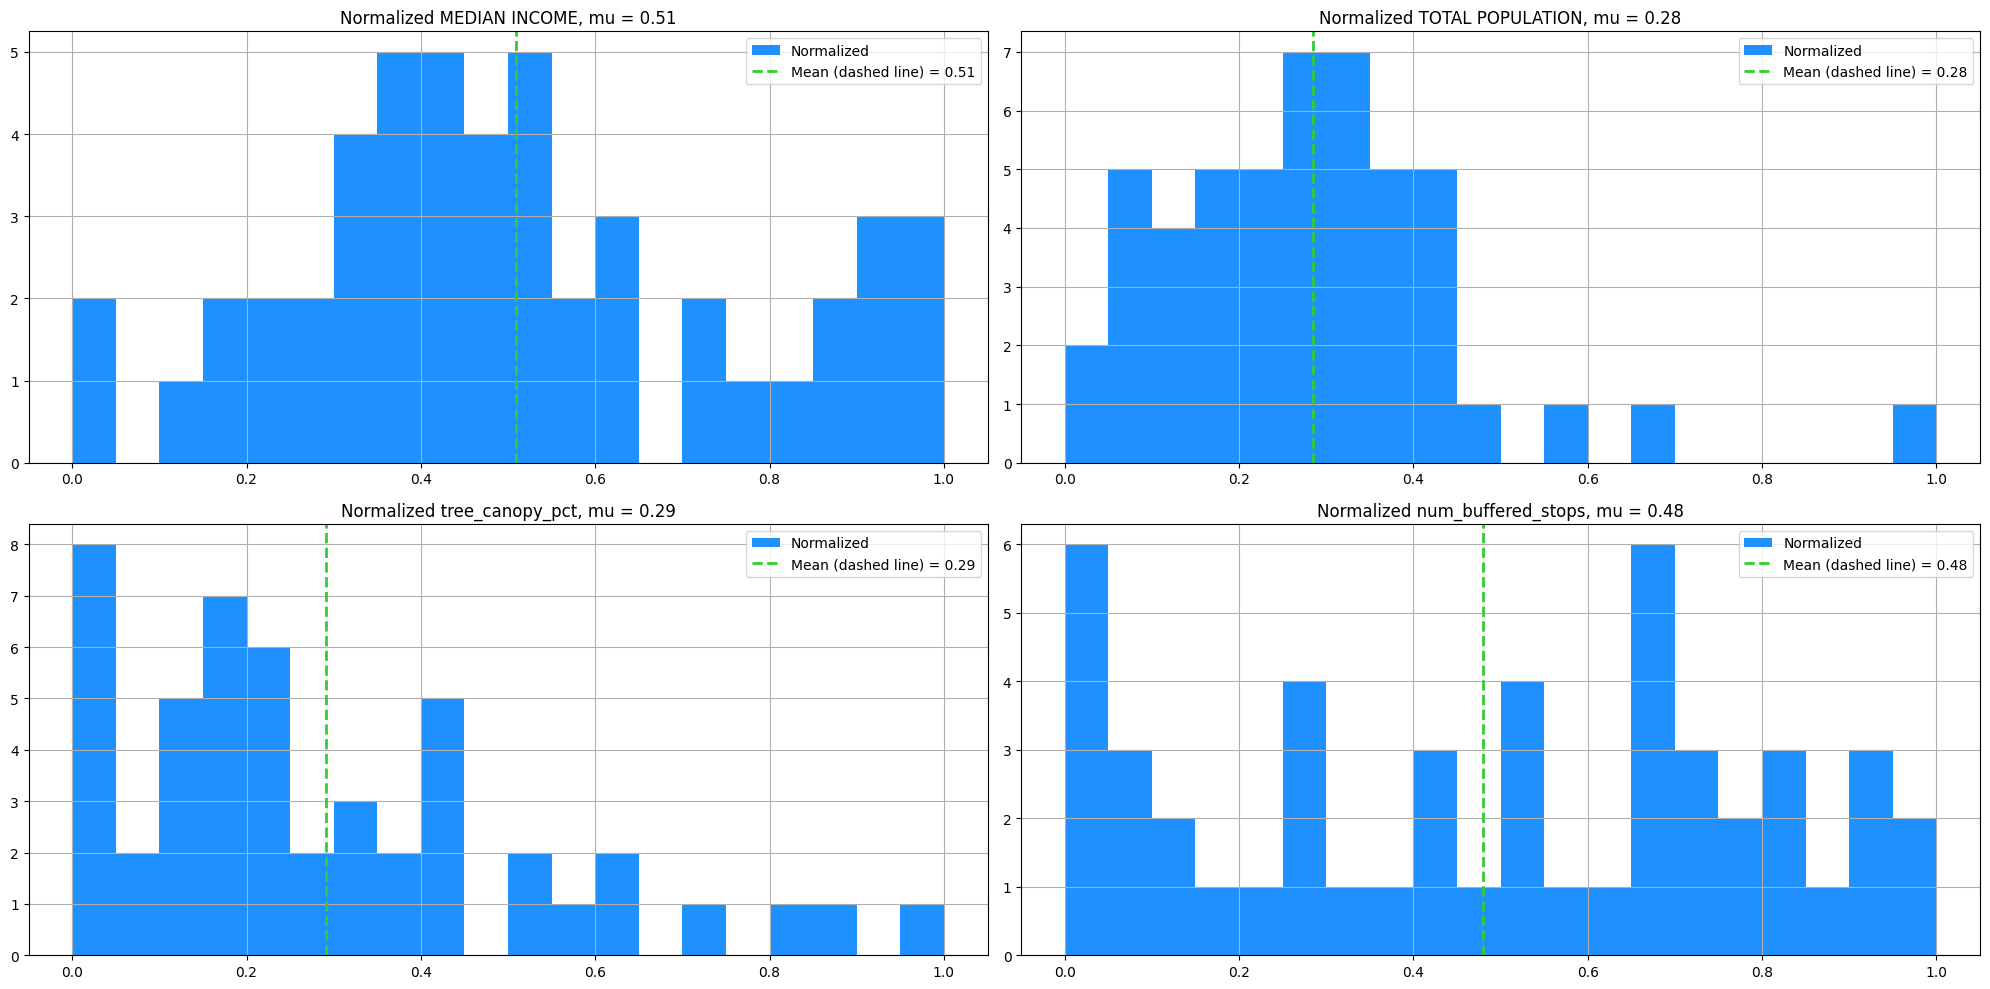

In [117]:
# Use this code cell to normalize each series' variables.
def normalize(df, col):
    x = df[col]
    min_x, max_x = np.min(x), np.max(x)
    return (x - min_x) / (max_x - min_x)

plt.subplots(nrows=2, ncols=2, figsize=(20,10))
for i, col in enumerate(cols):
    gdf_norm[col + '_norm'] = normalize(gdf_norm, col)
    ax = plt.subplot(2, 2, i+1)
    gdf_norm[col + '_norm'].hist(bins=20, ax=ax, color='dodgerblue', label='Normalized')
    # Add dashed mean line and label it so it appears in the legend
    ax.axvline(np.mean(gdf_norm[col + '_norm']), color='limegreen', linestyle='dashed', linewidth=2, label='Mean (dashed line) = {:.2f}'.format(np.mean(gdf_norm[col + '_norm'])))
    ax.set_title(f'Normalized {col}, mu = {np.mean(gdf_norm[col + "_norm"]):.2f}')
    ax.legend()
plt.tight_layout()


Normalized index summary:
count    49.000000
mean      0.391073
std       0.146300
min       0.111565
25%       0.309332
50%       0.394040
75%       0.449710
max       0.781032
Name: index_norm, dtype: float64


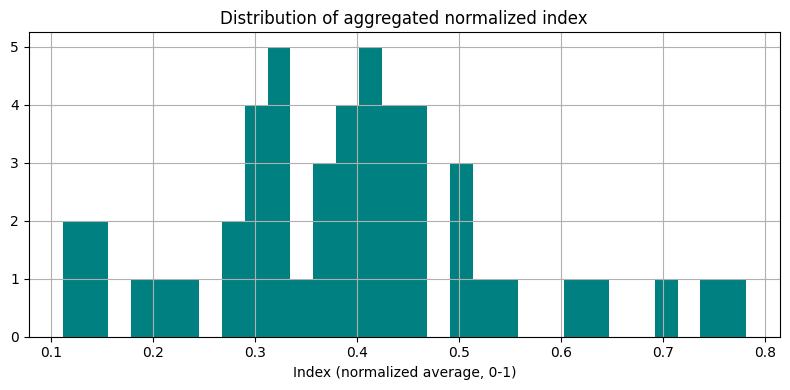

In [118]:
# Aggregate normalized columns into a single index (0-1 scale) by averaging
norm_cols = [c + '_norm' for c in cols]
gdf_norm['index_norm'] = gdf_norm[norm_cols].mean(axis=1)
print('Normalized index summary:')
print(gdf_norm['index_norm'].describe())
plt.figure(figsize=(8,4))
gdf_norm['index_norm'].hist(bins=30, color='teal')
plt.title('Distribution of aggregated normalized index')
plt.xlabel('Index (normalized average, 0-1)')
plt.tight_layout()
plt.show()

### Step 3: Compare Resulting Indices
Does the method for creating the index value affect the result?  Plot both the indices to compare their values.

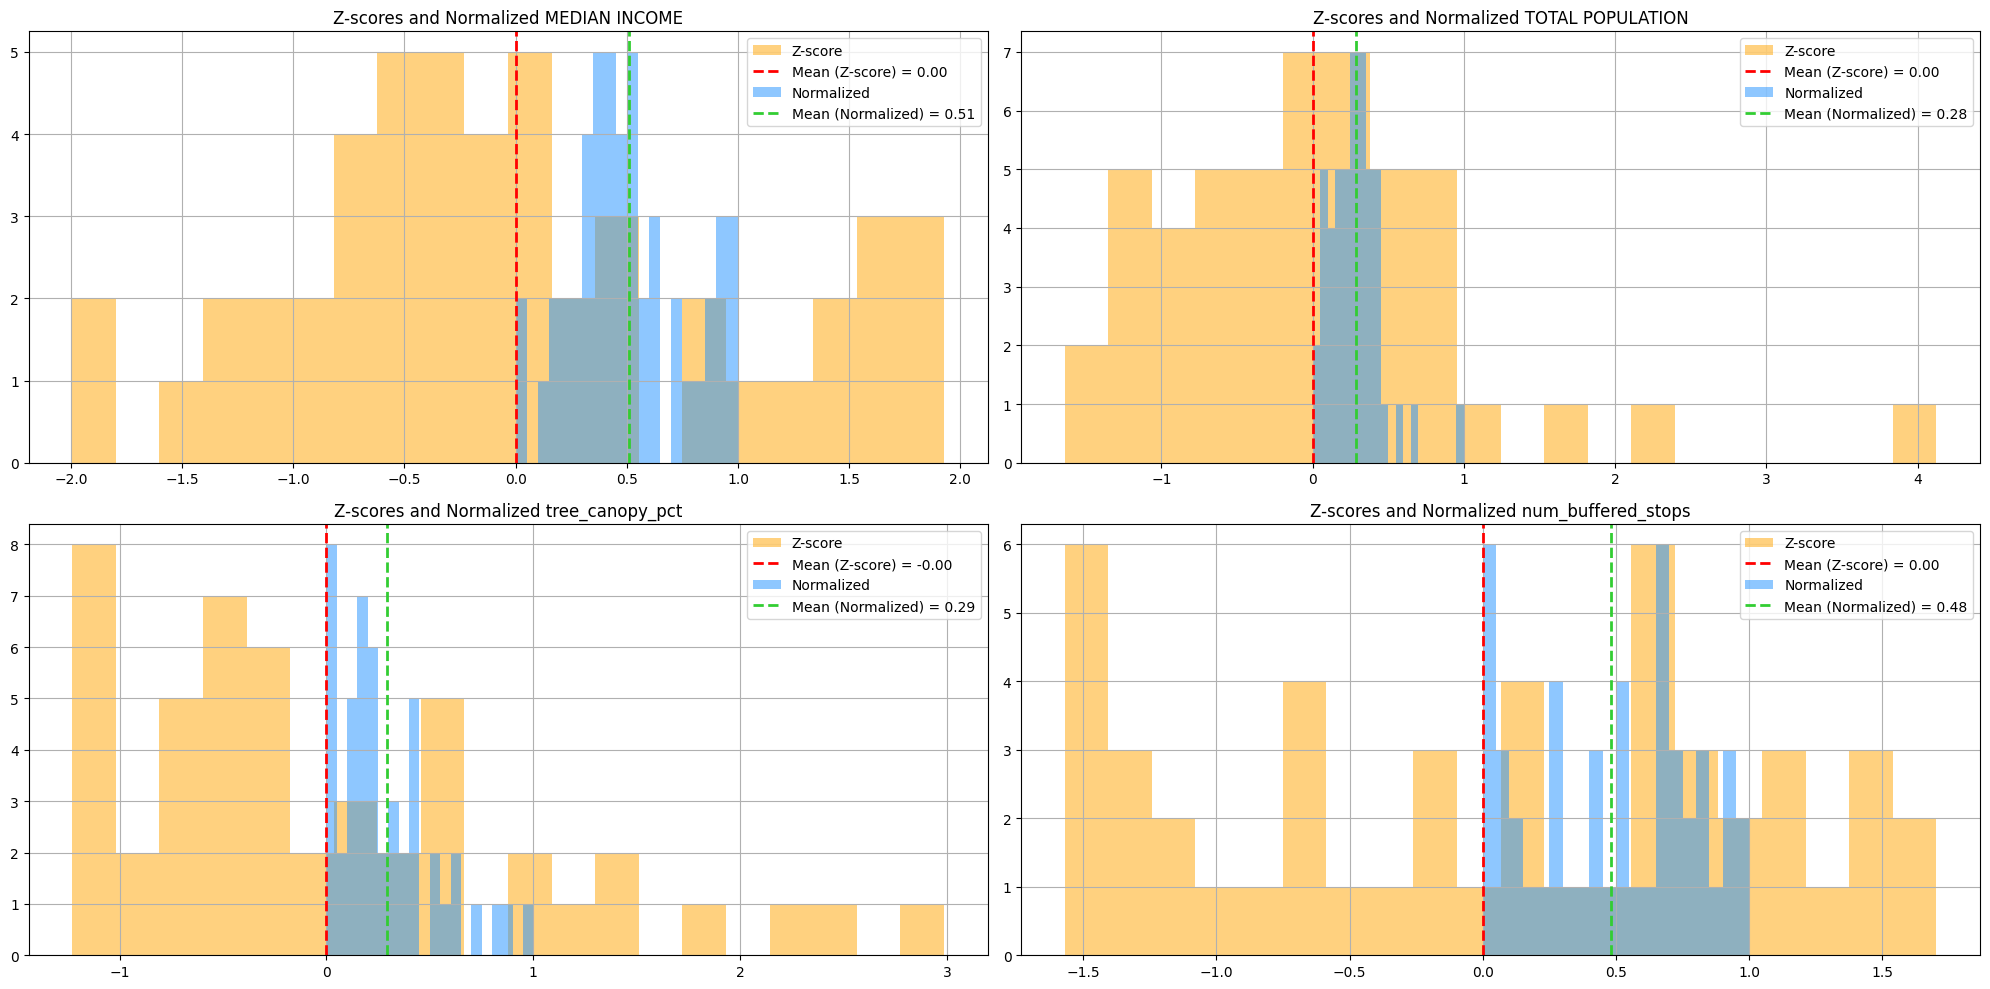

In [119]:
# Use this code cell to plot the the standardized index value
# Overlay z-scores over noramlized values
plt.subplots(nrows=2, ncols=2, figsize=(20,10))
for i, col in enumerate(cols):
    ax = plt.subplot(2, 2, i+1)
    gdf_norm[col + '_zscore'].hist(bins=20, alpha=0.5, label='Z-score', ax=ax, color='orange')
    # dashed mean for Z-score with label
    ax.axvline(np.mean(gdf_norm[col + '_zscore']), color='red', linestyle='dashed', linewidth=2, label='Mean (Z-score) = {:.2f}'.format(np.mean(gdf_norm[col + '_zscore'])))
    
    gdf_norm[col + '_norm'].hist(bins=20, alpha=0.5, label='Normalized', ax=ax, color='dodgerblue')
    # dashed mean for Normalized with label
    ax.axvline(np.mean(gdf_norm[col + '_norm']), color='limegreen', linestyle='dashed', linewidth=2, label='Mean (Normalized) = {:.2f}'.format(np.mean(gdf_norm[col + '_norm'])))
    ax.set_title(f'Z-scores and Normalized {col}')
    
    ax.legend()
plt.tight_layout()

Summary: index_z
count    4.900000e+01
mean    -1.132881e-17
std      5.833682e-01
min     -1.134842e+00
25%     -3.311265e-01
50%      7.517622e-04
75%      2.375274e-01
max      1.536601e+00
Name: index_z, dtype: float64

Summary: index_norm
count    49.000000
mean      0.391073
std       0.146300
min       0.111565
25%       0.309332
50%       0.394040
75%       0.449710
max       0.781032
Name: index_norm, dtype: float64


Text(0.5, 0, 'index_norm')

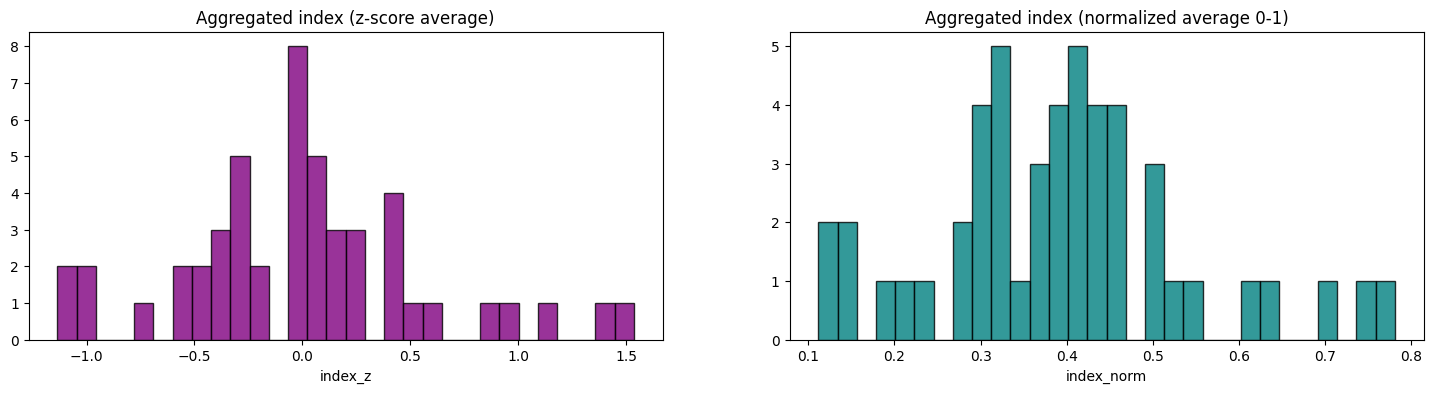

In [125]:
# Summary statistics
print('Summary: index_z')
print(gdf_norm['index_z'].describe())
print('\nSummary: index_norm')
print(gdf_norm['index_norm'].describe())


# Plot distributions side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18,4))
axes[0].hist(gdf_norm['index_z'].dropna(), bins=30, color='purple', alpha=0.8, edgecolor='k')
axes[0].set_title('Aggregated index (z-score average)')
axes[0].set_xlabel('index_z')

axes[1].hist(gdf_norm['index_norm'].dropna(), bins=30, color='teal', alpha=0.8, edgecolor='k')
axes[1].set_title('Aggregated index (normalized average 0-1)')
axes[1].set_xlabel('index_norm')

---

# Important Submission Instructions
* When you are done, be sure to submit this lab exercise to receive credit for attendance on 11/5 (Section 101) and 11/6 (Section 102).
* Begin work on the Lab #10 exercise once you have submitted your work for this lab.